May 2019<br>
An up to date version of this document is available at <a href='https://github.com/zlcc9/machine-learning'>github.com/zlcc9/machine-learning</a>

## 1. Introduction
This document serves as an appendix to a documented paper on the Mammographic Mass Data Set available from the UCI Machine Learning repository http://archive.ics.uci.edu/ml/datasets/mammographic+mass

This data set contains informations on 6 Variables:
1.	BI-RADS assessment (1 (definitely benign) to 5 (highly suggestive of malignancy))
2.	Age (Integer)
3.	Mass shape (1=round, 2=oval, 3=lobular, 4=irregular)
4.	Mass margin (1 = circumscribed, 2=microlobulated, 3=obscured, 4=ill-defined, 5=spiculated)
5.	Mass density (1=high, 2=iso, 3=low, 4=fat-containing) 
6.	Severity (0=benign,  1=malignant)

BI-RADS Assesment will be not be used a predictive feature, but can be used as a baseline to compare the models against.
Shape, Margin and Density are descriptors of the mass arranged from least to most suspicious of cancer.

### 1.1 Importing Data and Libraries

In [585]:
# Import basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style("white")
plt.rcParams['figure.figsize'] = (10,6)
#suppress warning 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Missing data is labelled '?' in the raw and will be changed to NaN which is the natural way of coding missing values in Numpy and Pandas

In [540]:
# Load data set
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'
columns = ['BI-RADS','Age', 'Shape','Margin','Density','Severity']
df = pd.read_csv(url, header=None, names=columns, na_values='?')
df.head(10)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
9,5.0,60.0,NaN,5.0,1.0,1


In [471]:
print(df['BI-RADS'].value_counts())

4.0     547
5.0     345
3.0      36
2.0      14
6.0      11
0.0       5
55.0      1
Name: BI-RADS, dtype: int64


One value of BI-RADS is mislabelled '55'.  This will be relabelled '5'.  BI-RADS category will then be removed from the main data set, and saved for later use.

In [472]:
# format incorrect BI-RADS and remove column for later use
df_BIRADS = df[['BI-RADS','Severity']]
df_BIRADS = df_BIRADS.replace(55,5)
df = df.drop('BI-RADS', axis=1)

### 1.2 Exploring Data Relations
Initial histograms of each feature reveal information about their distribution.

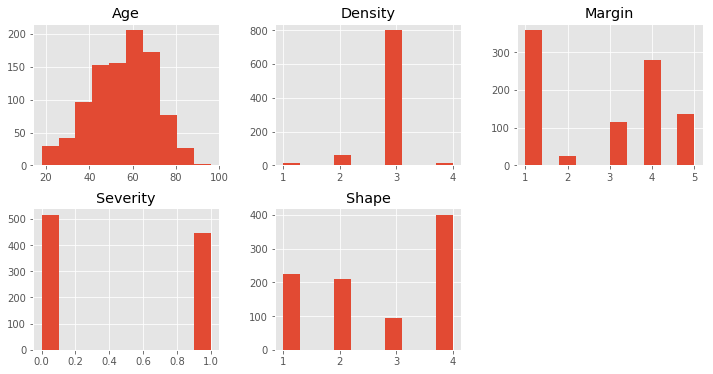

In [473]:
_ =df.hist(figsize=(12,6), layout=(2,3))

In [475]:
#Calculate percentage with malignant scan
df.Severity.sum()/len(df.Severity)*100

46.30593132154006

In [557]:
# show mean and range for age
df.Age.describe()

count    956.000000
mean      55.487448
std       14.480131
min       18.000000
25%       45.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: Age, dtype: float64

The data set is well-balanced with 46% positive class. Shape and margin have a much wider ditribution across categories than density.  Age has mean 55.5 (standard deviation 14.5)

Text(0.5, 1.0, 'Correlation Matrix')

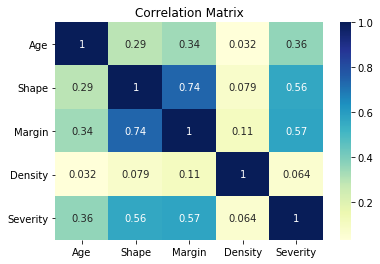

In [301]:
#Correlation
corr = df.corr()
ax = sns.heatmap(corr, annot = True, cmap="YlGnBu")
plt.setp(ax.axes.get_yticklabels(), rotation=0)
plt.title('Correlation Matrix')

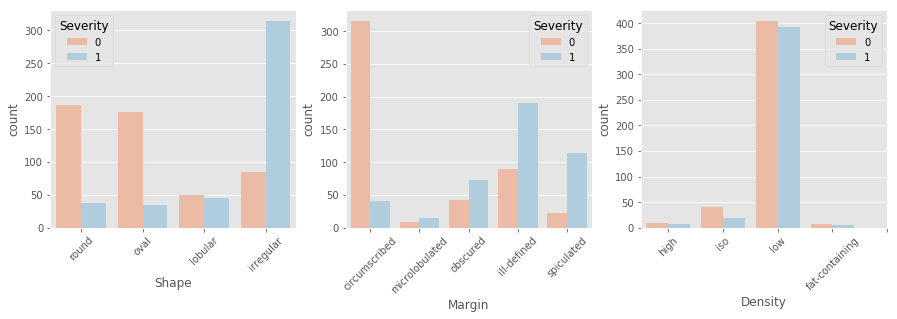

In [485]:
#PLot some more histograms, with class distribution
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.countplot(x='Shape', hue='Severity', data=df, palette='RdBu')
plt.xticks([0,1,2,3],['round', 'oval', 'lobular','irregular'], rotation=45)

plt.subplot(1,3,2)
sns.countplot(x='Margin', hue='Severity', data=df, palette='RdBu')
plt.xticks([0,1,2,3,4],['circumscribed', 'microlobulated', 'obscured', 'ill-defined','spiculated'], rotation=45)

plt.subplot(1,3,3)
sns.countplot(x='Density', hue='Severity', data=df, palette='RdBu')
plt.xticks([0,1,2,3,4],['high','iso','low','fat-containing'], rotation=45)

plt.show()

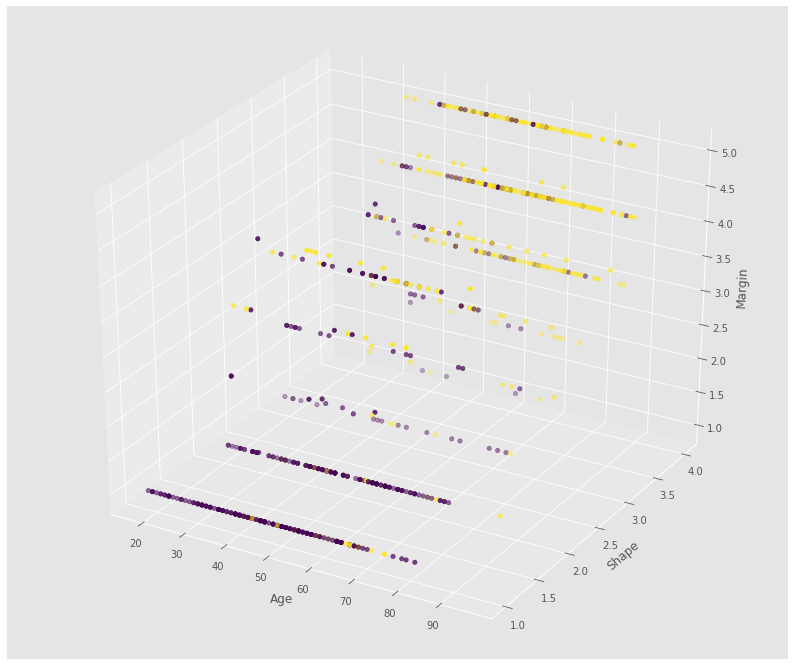

In [560]:
#Plot the 3 most informative features
from mpl_toolkits.mplot3d import Axes3D

#create features
df_complete = df.dropna(how='all') 


fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_complete['Age'], df_complete['Shape'], df_complete['Margin'], c=df_complete['Severity'])
ax.set_xlabel('Age')
ax.set_ylabel('Shape')
ax.set_zlabel('Margin')



plt.show()

## 2. Methods
### 2.1 Missing value Imputation
First check how many instances have missing values, and how many missing values from ech feature

In [445]:
from sklearn.impute import SimpleImputer

In [305]:
# Count missing values
df.isnull().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [306]:
#Count number missing multiple values
df['missing_count'] = df['Age'].isnull().astype(int) +\
                    df['Shape'].isnull().astype(int) +\
                    df['Margin'].isnull().astype(int) +\
                    df['Density'].isnull().astype(int)
missing_counter = Counter(df['missing_count'])
print(missing_counter)
df = df.drop(['missing_count'], axis=1)

Counter({0: 831, 1: 100, 2: 30})


In [308]:
# Split by target class for mean imputation
df0 = df[df['Severity']==0]
df1 = df[df['Severity']==1]

In [309]:
# show statistics for features by class
print('total\n', df.median(),'\n')
print('benign\n',df0.median(),'\n')
print('maliganant\n',df1.median(),'\n')

total
 Age         57.0
Shape        3.0
Margin       3.0
Density      3.0
Severity     0.0
dtype: float64 

benign
 Age         49.0
Shape        2.0
Margin       1.0
Density      3.0
Severity     0.0
dtype: float64 

maliganant
 Age         63.0
Shape        4.0
Margin       4.0
Density      3.0
Severity     1.0
dtype: float64 



In [310]:
# impute median values according to taret class
imr0 = SimpleImputer(missing_values=np.nan, strategy='median')  #or try strategy='most_frequent'
imr0 = imr0.fit(df0)
imputed_data0 = imr.transform(df0.values)

imr1 = SimpleImputer(missing_values=np.nan, strategy='median')
imr1 = imr1.fit(df1)
imputed_data1 = imr.transform(df1.values)

imputed_data = np.concatenate((imputed_data0, imputed_data1), axis=0)

In [525]:
imputed_df = pd.DataFrame(data=imputed_data, columns=columns[1:])
imputed_df.head()

,Age,Shape,Margin,Density,Severity
0,28.0,1.0,1.0,3.0,0.0
1,65.0,1.0,1.0,3.0,0.0
2,70.0,2.0,1.0,3.0,0.0
3,42.0,1.0,1.0,3.0,0.0
4,64.0,1.0,1.0,3.0,0.0


### 2.2 Baseline model based on BI-RADS

The plot below illustrates that depending on the threshold that is chosen, if BI-RADS alone is used to detect malignancy then a threshold of 4 or more will have high sensitivity (recall 0.98) but a low specificity (precision 0.48), while a threshold of 5 or above will have high specificity (precision 0.88) and lower sensitivity (0.71). 

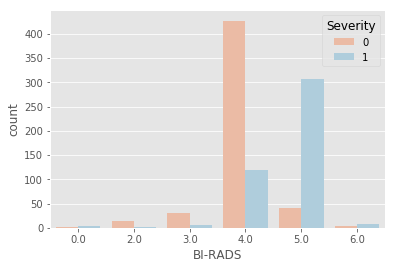

In [352]:
# Plot distribution of BI-RADS
sns.countplot(x='BI-RADS', hue='Severity', data=df_BIRADS, palette='RdBu')

In [488]:
#drop values that are out of range 1-5
df_BIRADS = df_BIRADS[df_BIRADS['BI-RADS']!=0]
df_BIRADS = df_BIRADS[df_BIRADS['BI-RADS']!=6]

# Make predictions based on threshold 4 or more
df_BIRADS['Prediction4'] = (df_BIRADS['BI-RADS']>=4).astype(int)
y_test_BIRAD = df_BIRADS['Severity']
y_pred_BIRAD4 = df_BIRADS['Prediction4']
print('\nClassification Report: Threshold BI-RADS 4\n',classification_report(y_test_BIRAD,y_pred_BIRAD4))

# Make predictions based on thrshold 5 or more
df_BIRADS['Prediction5'] = (df_BIRADS['BI-RADS']>=5).astype(int)
y_pred_BIRAD5 = df_BIRADS['Prediction5']
print('\nClassification Report: Threshold BI-RADS 5\n',classification_report(y_test_BIRAD,y_pred_BIRAD5))


Classification Report: Threshold BI-RADS 4
               precision    recall  f1-score   support

           0       0.85      0.09      0.16       511
           1       0.48      0.98      0.64       434

   micro avg       0.50      0.50      0.50       945
   macro avg       0.66      0.53      0.40       945
weighted avg       0.68      0.50      0.38       945


Classification Report: Threshold BI-RADS 5
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       511
           1       0.88      0.71      0.78       434

   micro avg       0.82      0.82      0.82       945
   macro avg       0.84      0.81      0.82       945
weighted avg       0.83      0.82      0.82       945



Although in clinical practice, a recall of 0.71 would be unacceptable for a screening test, for the purposes of a comparison, a threshold of 5 has a higher accuracy, so this level of accuracy will be used as a benchmark.

In [642]:
print("Accuracy at threshold 4: {0:.4f}".format(accuracy_score(y_test_BIRAD, y_pred_BIRAD4)))
print("Accuracy at threshold 5: {0:.4f}".format(accuracy_score(y_test_BIRAD, y_pred_BIRAD5)))
print('\Confusion Matrix: Threshold BI-RADS 5\n',confusion_matrix(y_test_BIRAD,y_pred_BIRAD5))

Accuracy at threshold 4: 0.4974
Accuracy at threshold 5: 0.8222
\Confusion Matrix: Threshold BI-RADS 5
 [[471  40]
 [128 306]]


## 2.2 Train-Test Split
In order to obtain an unbiased estimate of a model’s performance, it must be evaluated on an unseen test set, so the data is partitioned to create a hold-out set of data for later testing on.  The data is randomly split, but using a random state so that the model is reproducible.

In [490]:
from sklearn.model_selection import train_test_split

In [502]:
X = imputed_data[:,0:4].astype(float)
y=imputed_data[:,4].astype(int)

In [564]:
#split data into training and test portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## 2.3  K-Nearest Neighbour Model
The first model to be used is K-nearest neighbours.  Features for this model need to be numerical.  Although the features are categorical, they are on an ordinal scale from least to most malignant, so could be used in this application

In [542]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [644]:
#Running gridsearch cv with a pipeline

steps = [('normalize', MinMaxScaler()),
        ('knn',KNeighborsClassifier())]

knn_pipeline = Pipeline(steps)


#Mincowski (default) with p=1 is equivalent to Manhattan, p=2 equiv to Euclidian
param_grid = {'knn__n_neighbors': np.arange(1,50),
             'knn__p': [1,2],
             'knn__weights' : ['uniform','distance']} 

#set up grid search
knn_cv = GridSearchCV(knn_pipeline,param_grid, cv=10)

knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}
0.8033854166666666


In [621]:
#repeat grid search for F1, precision, recall
for score in [ 'precision','recall','f1']:
    knn_cv_alt = GridSearchCV(knn_pipeline,param_grid, cv=10, scoring=score)
    knn_cv_alt.fit(X_train, y_train)
    print(score)
    print(knn_cv_alt.best_params_)
    print(knn_cv_alt.best_score_)
    print(pd.DataFrame(knn_cv))

precision
{'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
0.7674975951592081
recall
{'knn__n_neighbors': 21, 'knn__p': 1, 'knn__weights': 'uniform'}
0.8256851438492063
f1
{'knn__n_neighbors': 17, 'knn__p': 1, 'knn__weights': 'uniform'}
0.7799653917644073


In [607]:
# results for knn_cv on training data
y_pred = knn_cv.predict(X_train)
print('Accuracy:', knn_cv.score(X_train,y_train))
print(classification_report(y_train, y_pred))

Accuracy: 0.8190104166666666
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       412
           1       0.79      0.84      0.81       356

   micro avg       0.82      0.82      0.82       768
   macro avg       0.82      0.82      0.82       768
weighted avg       0.82      0.82      0.82       768



### K-nearest Neighbour Results

In [609]:
# results for knn_cv on testing data
y_pred = knn_cv.predict(X_test)
print('Accuracy:', knn_cv.score(X_test,y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

Accuracy: 0.8238341968911918
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       104
           1       0.78      0.85      0.82        89

   micro avg       0.82      0.82      0.82       193
   macro avg       0.82      0.83      0.82       193
weighted avg       0.83      0.82      0.82       193

[[83 21]
 [13 76]]


In [610]:
# Sensitivity analysis: without normalizing data
steps = [('knn',KNeighborsClassifier())]

knn_pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(1,22,2),
             'knn__p': [1,2],
             'knn__weights' : ['uniform','distance',]} 

#set up grid search
knn_cv_unscaled = GridSearchCV(knn_pipeline,param_grid, cv=10)

knn_cv_unscaled.fit(X_train, y_train)
print(knn_cv_unscaled.best_params_)
print('Accuracy:',knn_cv_unscaled.best_score_)

y_pred = knn_cv_unscaled.predict(X_test)
print(classification_report(y_test, y_pred))

{'knn__n_neighbors': 13, 'knn__p': 1, 'knn__weights': 'uniform'}
Accuracy: 0.7864583333333334
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       104
           1       0.76      0.83      0.79        89

   micro avg       0.80      0.80      0.80       193
   macro avg       0.80      0.80      0.80       193
weighted avg       0.80      0.80      0.80       193



In [612]:
knn_cv_unscaled.score(X_test,y_test)

0.7979274611398963

In [652]:
# Sensitivity analysis: without Margin data
X_train_nomarg = X_train[:,[0,1,3]]
X_test_nomarg = X_test[:,[0,1,3]]

steps = [('normalize', MinMaxScaler()),
         ('knn',KNeighborsClassifier())]

knn_pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(1,50,2),
             'knn__p': [1,2],
             'knn__weights' : ['uniform','distance',]} 

#set up grid search
knn_cv_nomarg = GridSearchCV(knn_pipeline,param_grid, cv=10)

knn_cv_nomarg.fit(X_train_nomarg, y_train)
print(knn_cv_nomarg.best_params_)
print('Accuracy:',knn_cv_nomarg.best_score_)

y_pred_nomarg = knn_cv_nomarg.predict(X_test_nomarg)
print(classification_report(y_test, y_pred_nomarg))

{'knn__n_neighbors': 33, 'knn__p': 1, 'knn__weights': 'uniform'}
Accuracy: 0.78515625
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       104
           1       0.77      0.80      0.78        89

   micro avg       0.80      0.80      0.80       193
   macro avg       0.80      0.80      0.80       193
weighted avg       0.80      0.80      0.80       193



### Decision Tree
Decision trees have many parameters that can be tuned, such as max_features, max_depth, and min_samples_leaf:

In [623]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1,2,3,4,5,6,7,8,9, None],
          "max_features": [1,2,3,4],
          "min_samples_leaf": np.arange(1, 9,2),
          "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=10)

# Fit it to the data
tree_cv.fit(X_train,y_train)

#Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 3}
Best score is 0.80078125


In [628]:
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=5, max_features=4, min_samples_leaf=3)
tree_cv.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

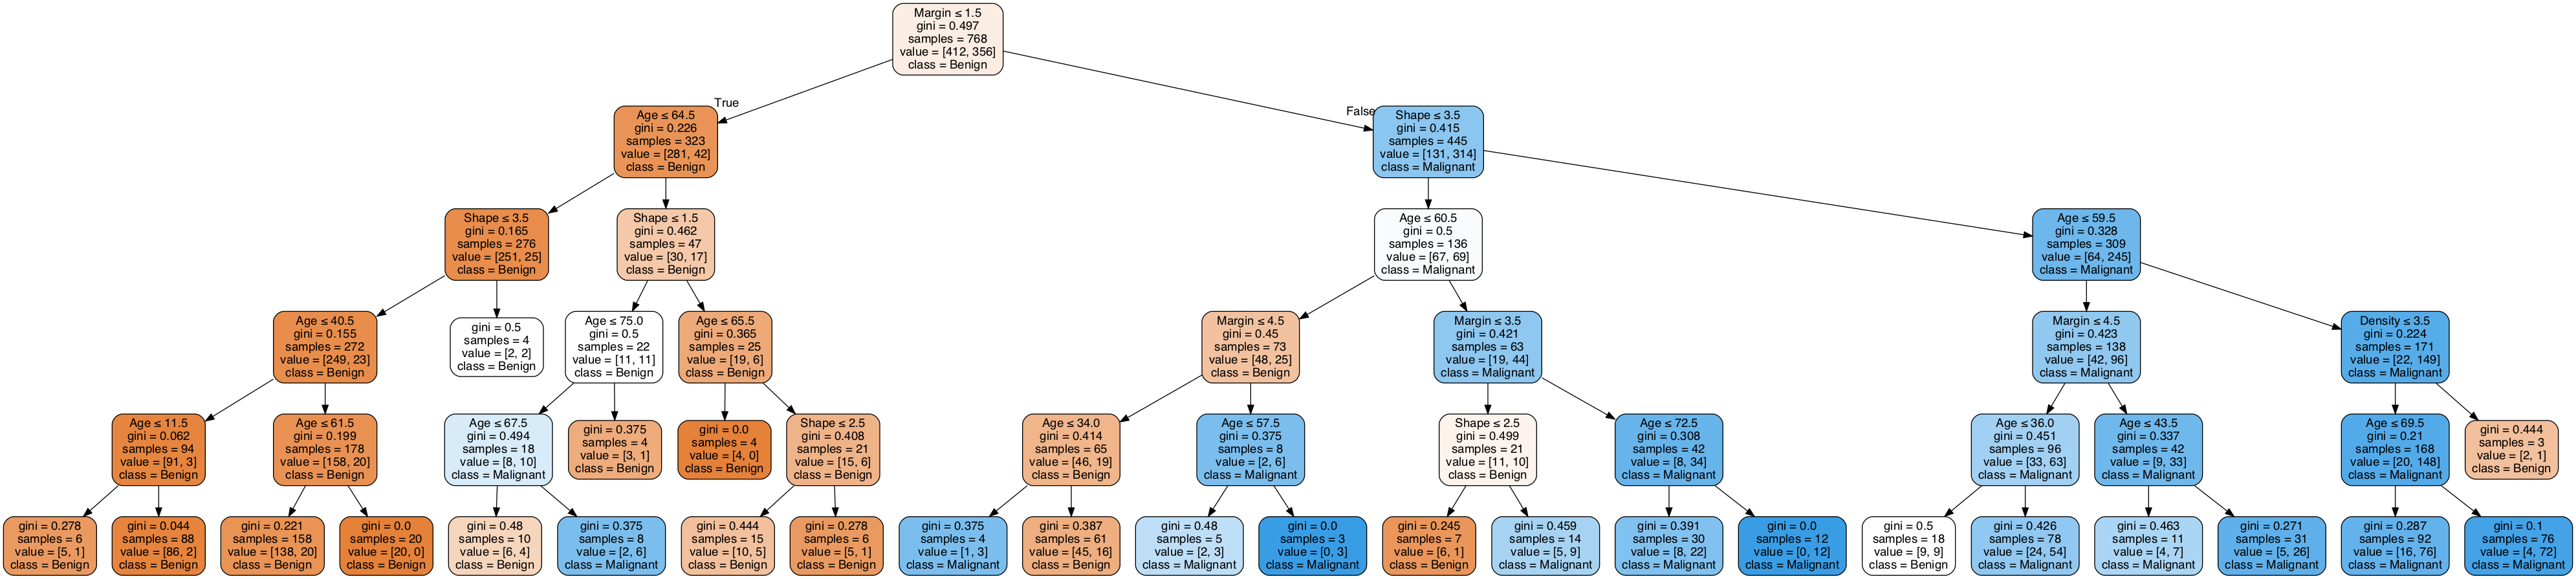

In [629]:
import graphviz 
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
dot_data=StringIO()
dot_data = export_graphviz(tree_cv, out_file = None, feature_names=columns[1:-1], class_names=['Benign', 'Malignant'], 
                filled=True, rounded=True, special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
#print(dot_data)
Image(graph.create_png())

### Decision Tree Results

In [641]:
y_pred = tree_cv.predict(X_test)
print('Accuracy:',tree_cv.score(X_test,y_test))
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred))
print('Classification Report')
print(classification_report(y_test,y_pred))

Accuracy: 0.8134715025906736
Confusion Matrix
[[83 21]
 [15 74]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       104
           1       0.78      0.83      0.80        89

   micro avg       0.81      0.81      0.81       193
   macro avg       0.81      0.81      0.81       193
weighted avg       0.82      0.81      0.81       193



### Additional plots

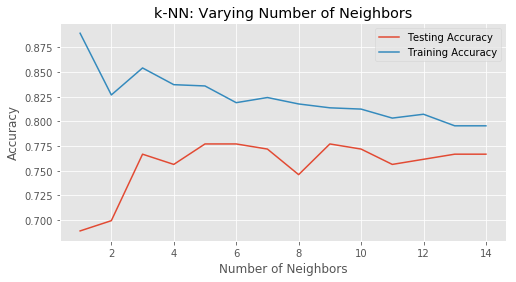

In [554]:
# Different number of k
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.figure(figsize=(8,4))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


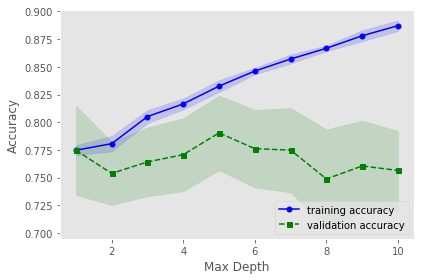

In [563]:
from sklearn.model_selection import validation_curve

tree=DecisionTreeClassifier()

# Range of max_depth paramter for 
param_range = [1,2,3,4,5,6,7,8,9,10]
train_scores, test_scores = validation_curve(
                estimator=tree, 
                X=X_train, 
                y=y_train, 
                param_name='max_depth', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

###  A ROC Curve for models

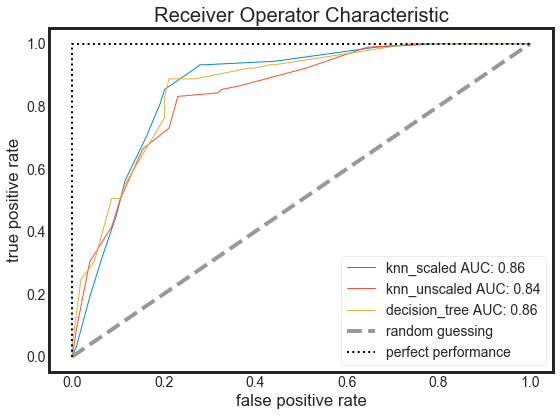

In [639]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fig = plt.figure(figsize=(8, 6))
all_tpr = []

pipelines = [('knn_scaled', knn_cv),
            ('knn_unscaled',knn_cv_unscaled),
            ('decision_tree', tree_cv)]
for name, model in pipelines:
      
    model.fit(X_train, y_train)
    
    probas = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    current_auc = str('%.2f' %roc_auc)
    
    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label= str(name + ' AUC: ' + current_auc))

plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='random guessing')

plt.plot([0, 0, 1], 
         [0, 1, 1], 
         lw=2, 
         linestyle=':', 
         color='black', 
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()